<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h6><center>Introduction to Machine Learning</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Tutorial 2: Data preprocessing (real data)</center>
<hr style=" border:none; height:3px;">
</h1>

__Teachers__: Myriam Tami, Gianluca Quercini, Yassine Ouali

# Introduction

In this tutorial we're going to play with some real data and learn the full pipeline of data preprocessing, training and testing a machine learning algorithm.

<div class="alert alert-block alert-info">

For the most part, the Python code is already written for you. You're invited to **read the code and the comments** to learn how to practice machine learning with *Scikit-learn*. Your instructor will also explain the code.

</div>



# Setup

We import the modules that are commonly used in combination with Scikit-learn.

<div class="alert alert-block alert-warning">
In order to run this notebook, you'll need to install <b>Python 3.5 or later</b>, as well as <b>Scikit-learn 0.20 or later</b>.
</div>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Numpy arrays are used to store training and test data.
import numpy as np

# Pandas is used to manipulate tabular data.
import pandas as pd

# Matplotlib is used to plot graphs.
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998).
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Convenience function to create display a progress bar.
# Source : https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def print_progress_bar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
 
# Saves a figure to a file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./figs", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Experimenting with real data

We're going to use a dataset containing California census data. This dataset appeared in a 1997 paper titled *Sparse Spatial Autoregressions* by Pace, R. Kelley and Ronald Barry, published in the *Statistics & Probability Letters* journal. The dataset is built using the 1990 California census data. It contains one row per census district. A district is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (population of 600 to 3,000 people).

Given this dataset, **our goal** is to train a machine learning model to **predict the median house value in a given district**.

<div class="alert alert-block alert-info">

This tutorial is based on Chapter 2 of the book <i>"Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow"</i> by Aurélien Géron.

</div>

The code in the following cell downloads the dataset from its source and stores it under the folder *./datasets* in your working directory.

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

if not os.path.isfile(os.path.join(HOUSING_PATH, "housing.csv")):
    fetch_housing_data()

The dataset is a **CSV file**. We can load it into a **Pandas dataframe** by using the function $read\_csv()$ of the library *Pandas*.


<div class="alert alert-block alert-info">

In the first tutorial we directly manipulated *Numpy arrays*. Using *Pandas dataframes* offers many advantages, for example features are identified by a name and many functions help with data preprocessing, as we'll see later in the tutorial.

</div>

The following cell loads the dataset into the dataframe $housing$.

In [3]:
csv_path = os.path.join(HOUSING_PATH, "housing.csv")
housing = pd.read_csv(csv_path)

We can invoke the function $head()$ on the dataframe $housing$ in order to  display the first five instances of the dataset.
Each row represents a district, described by 10 features.

<div class="alert alert-block alert-info">
    
The first column does not have a header; it corresponds to a row identifier used by Pandas and is not part of the dataset (it is not a feature).
    
</div>

<div class="alert alert-block alert-success">

**Question 1.** Specify the type of each feature in this dataset (categorical/numeric, nominal/ordinal, continuous/discrete).

</div>

In [13]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<div class="alert alert-block alert-success">
    
**Solution.**

1. **Numeric continuous features**: longitude, latitude, median_income, median_house_value.

2. **Numeric discrete features:** housing_median_age, total_rooms, total_bedrooms, population, households

3. **Categorical nominal features:** ocean_proximity.

</div>

By invoking the function $info()$ on the Dataframe $housing$, we can get some more information on the dataset, its features and its values.

<div class="alert alert-block alert-success">

**Question 2.** Read the output and interpret the result. Is there any missing value in this dataset?

</div>

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<div class="alert alert-block alert-success">

**Solution.** The output specifies that:

1. There are **20640 instances** (entries) in the dataset.

2. There are **10 features** (columns) in the dataset.

3. For each feature, its type and the number of non-null values.

There are 207 instances with a missing value in feature $total\_bedrooms$.

</div>

We can invoke the function $describe()$ on the Dataframe $housing$ to get a summary of the numeric features.

<div class="alert alert-block alert-success">

**Question 3.** Explain the output of the function $describe()$.

</div>



In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<div class="alert alert-block alert-success">

**Solution.** For each feature we have access to a certain number of statistics (total number of instances, mean, standard deviation, minimum value, 25th percentile, the median, the 75th percentile and the maximum value). 

<div class="alert alert-block alert-info">

**Reminder.** A **percentile** indicates the value below which a given percentage of instances fall. For instance, 25% of the districts have a housing median age lower than 18.

</div>

</div>

We can have a better view of the numerical data by plotting some histograms.

<div class="alert alert-block alert-info">

**Note.** Unlike the first tutorial, where we had to explicitly use *Matplotlib* functions to plot some graphs with *Numpy arrays*, here we can use plotting functions directly on the Dataframe.

</div>


<div class="alert alert-block alert-success">
    
**Question 4.** Execute the following cell. 

1. Is there anything you notice about the values of $median\_house\_value$?

2. What can you say about the values of $median\_income$?

2. What can you say about the scale of the different features?

</div>

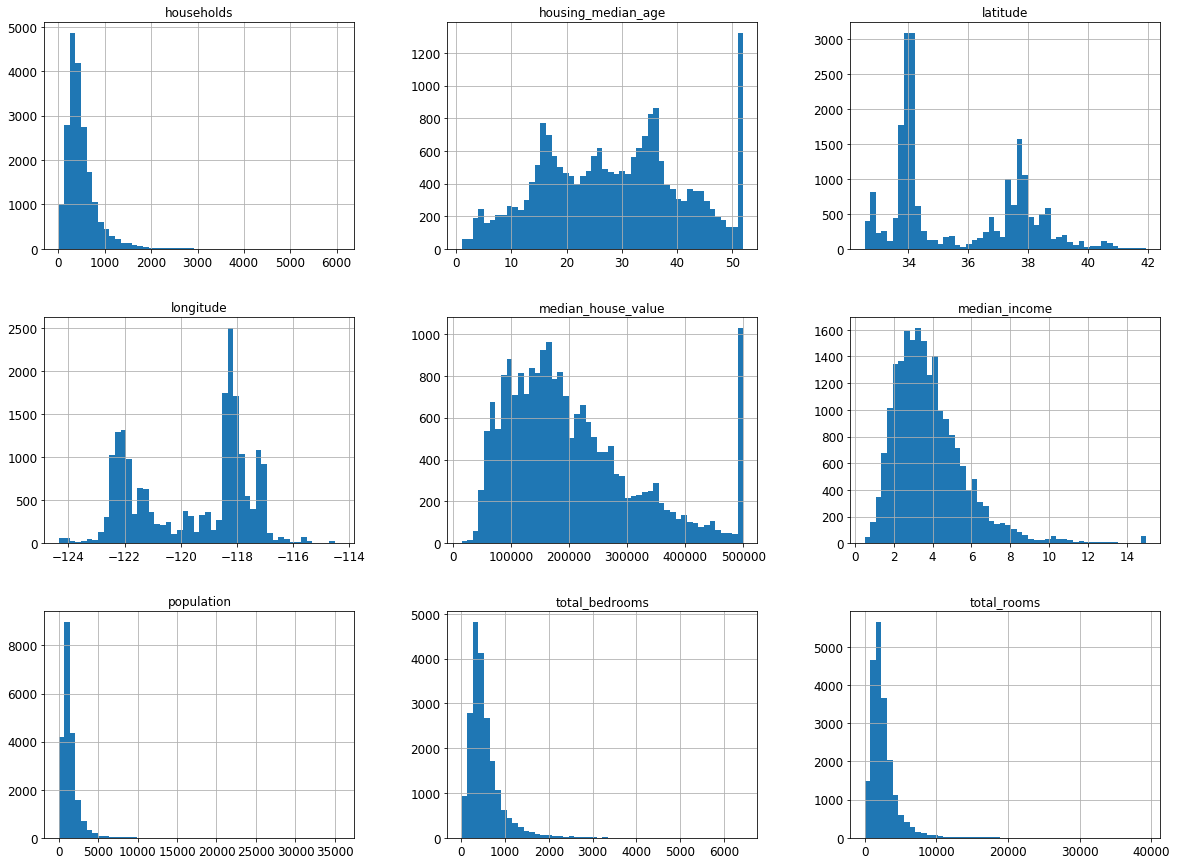

In [ ]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

<div class="alert alert-block alert-success">

**Solution.** 

1. Most of the instances have value 500,000 (the maximum value). This shows that the values of this feature have been capped. This might be a problem, as $median\_house\_value$ is the target variable to predict. Note that we observe the same pattern for feature $housing\_median\_age$ that seems to be capped at 50.

2. The values of $median\_income$ vary between 0 and 15. Values have been scaled. In order to obtain the actual value, we need to multiply the scaled value by 10,000. So, 3 corresponds to a median income of 30,000.

3. Features have very different scales. We'll need to rescale them later on.

</div>

The previous histograms show the distribution of values of numeric features. For categorical features, there isn't any function that plots all the histograms at once. 
We obtain information on a categorical feature by invoking the function $value\_counts()$ on the column corresponding to that feature.

<div class="alert alert-block alert-success">
    
**Question 5.** Execute the following cell and interpret the output of the function $value\_counts()$.

</div>

In [19]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

<div class="alert alert-block alert-success">

**Solution.** For each value of the feature, the output states the number of instances having that value.
For instance, there are 9136 instances with the value "<1H OCEAN" for the feature $ocean\_proximity$.

</div>

Execute the following cell if you want to plot an histogram of the values of the categorical feature.

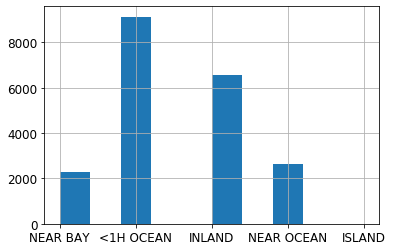

In [ ]:
housing['ocean_proximity'].hist()

We can also create new features if we need them. In the following cell we add a feature $income\_cat$ that applies a discretization of the feature $median\_income$ into 5 categories: category 1 corresponds to a median income between 0 and 1.5, category 2 corresponds to a median income between 1.5 and 3 and so on.

In [24]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

## Create a test set

<div class="alert alert-block alert-success">
    
**Question 6.** Complete the following code in order split the dataset into a training and test set.

</div>

<div class="alert alert-block alert-info">

**Tip.** Use the function $train\_test\_split$ that you used in the first tutorial.
Unlike the first tutorial, the function returns two dataframes $train\_set$ and $test\_set$. 

</div>

In [27]:
# COMPLETE THE CODE
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In the following cell we compare the income category proportions in the input dataset against the proportions in the test set and we calculate the error on each income category (the **sampling bias**).

<div class="alert alert-block alert-success">
    
**Question 7.** What do you notice?

</div>

In [28]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


compare_props = pd.DataFrame({
    "Input_dataset": income_cat_proportions(housing),
    "Test_set": income_cat_proportions(test_set),
}).sort_index()
compare_props["Test set. %error"] = 100 * compare_props["Test_set"] / compare_props["Input_dataset"] - 100

compare_props

,Input_dataset,Test_set,Test set. %error
1,0.039826,0.040213,0.973236
2,0.318847,0.324370,1.732260
3,0.350581,0.358527,2.266446
4,0.176308,0.167393,-5.056334
5,0.114438,0.109496,-4.318374


<div class="alert alert-block alert-success">
    
**Solution.** Random sampling of the test set significantly alters the income category proportions that we have in the input dataset. This might be a problem, because the median income is highly likely to be an important feature to predict the median house value

</div>

A solution to the problem pointed out in the previous question is to resort to __stratified sampling__.
With stratified sampling, we create a test set that preserves the proportions of the income categories of the input dataset.
The following cell shows how to do it.

In [29]:
strat_train_set, strat_test_set =\
train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42, shuffle=True)

If you run the following cell, you'll see by yourself that with stratified sampling the sampling bias is much lower than with random sampling.

In [30]:
compare_props = pd.DataFrame({
    "Input_dataset": income_cat_proportions(housing),
    "Test_set": income_cat_proportions(test_set),
    "Stratified": income_cat_proportions(strat_test_set),
}).sort_index()
compare_props["Test set. %error"] = 100 * compare_props["Test_set"] / compare_props["Input_dataset"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Input_dataset"] - 100

compare_props

,Input_dataset,Test_set,Stratified,Test set. %error,Strat. %error
1,0.039826,0.040213,0.039729,0.973236,-0.243309
2,0.318847,0.324370,0.318798,1.732260,-0.015195
3,0.350581,0.358527,0.350533,2.266446,-0.013820
4,0.176308,0.167393,0.176357,-5.056334,0.027480
5,0.114438,0.109496,0.114583,-4.318374,0.127011


<div class="alert alert-block alert-info">

Always consider using stratified sampling when you need to maintain in the test set the same value distributions of a feature as in the whole dataset.
**Caveat.** In this example the numeric variable has been artificially transformed into a categorical one. This allowed us to do stratified sampling. If we only have numeric variables, then the only available option is to resort to random sampling.

</div>

We're now going to analyze the data in more depth. For this task, we **set aside the test set** and we **only focus on the training set**. 

At this stage, it would be tempting to use the whole dataset in order to analyze the data. However, if we find some interesting patterns on the whole dataset and we use them to train a machine learning model, the evaluation on the test set would definitely be biased (this is called **data snooping bias**). The test set must be treated as a set of data that we know virtually nothing about.

Since we're going to play with the training set, it is more prudent to make a copy of it.

In [31]:
housing_copy = strat_train_set.copy()

## Looking for correlations

Since the dataset is not too big, we can compute the __correlation matrix__, where each cell contains the standard correlation coefficient (a.k.a., Pearson's $r$) between two features.

In [32]:
corr_matrix = housing_copy.corr()

By executing the following cell, you obtain the correlation coefficient of each feature with $median\_house\_value$, the target variable that we need to predict.

<div class="alert alert-block alert-success">
    
**Question 8.** Comment the result.

</div>

In [33]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [26]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

<div class="alert alert-block alert-success">
    
**Solution.** The correlation analysis clearly shows that $median\_income$ has a strong positive correlation with 
$median\_house\_value$, which justifies our choice to do a stratified sampling of the test set based on that feature. The other correlations are very weak.
The negative correlation of $latitude$ with $median\_house\_value$ is very weak, but it shows a slight tendency of northern districts to have more expensive houses.

</div>

In the following cell, we plot the correlation between the most important features, as revealed by the correlation analysis above. The following code produces a matrix $S$, where each row and column corresponds to a feature. The cell $M[r, c]$ contains the plot of the correlation between features $r$ and $c$; the cell $M[r, r]$ contains the histogram of the values of $r$.

We can zoom in the correlation between $median\_income$ and $median\_house\_value$.

<div class="alert alert-block alert-success">

__Question 9.__ Is there anything that strikes you in this plot?

</div>

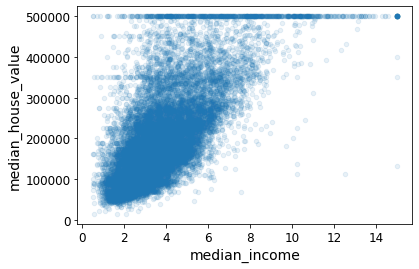

In [34]:
housing_copy.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

<div class="alert alert-block alert-success">
    
**Solution.** The graph clearly shows that there is indeed a strong linear correlation between the two variables. 
We can also clearly see that there is a straight line at the maximum value of $median\_house\_value$. Once again, we see that the values of $median\_house\_value$ are artificially capped. For some reasons, districts where the median house value is higher than 500,000 are capped to 500,000. We'll see later that this has a negative impact on the predictions. Similar horizontal lines can be observed at 450,000 and 350,000.

</div>

## Feature engineering

While analyzing the data, we might want to __create new features__ that are obtained as a combination of the existing ones. This is called __feature engineering__. 
In our example, we might notice that there isn't any feature that gives an indication of the surface of a house; we do have the feature $total\_rooms$, but its values indicate the total number of rooms in a district, and gives no indication as to the surface of a house.

<div class="alert alert-block alert-success">

__Question 10.__ Propose a new feature that uses the feature _total_rooms_ in combination with another feature to have an indication of the surface of a house.

</div>

<div class="alert alert-block alert-success">
    
**Solution.** We can compute the number of rooms per household, that gives an idea of the number of rooms (and, therefore, the surface) of a house. The code to add the new feature is shown below.
</div>

In [36]:
# SOLUTION
housing_copy["rooms_per_household"] = housing_copy["total_rooms"]/housing_copy["households"]

<div class="alert alert-block alert-success">

__Question 11.__ Run the correlation analysis again and see if the new feature is useful.

</div>

In [37]:
#SOLUTION
corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.687160
rooms_per_household    0.146285
total_rooms            0.135097
housing_median_age     0.114110
households             0.064506
total_bedrooms         0.047689
population            -0.026920
longitude             -0.047432
latitude              -0.142724
Name: median_house_value, dtype: float64

<div class="alert alert-block alert-success">
    
**Solution.** We can see that the new feature $rooms\_per\_household$ has a slightly higher correlation with the target variable than $total\_rooms$, though the correlation is still very weak.
</div>

Another information that is missing is that we don't have any indication of the number of rooms that are used as bedrooms; so, we can compute the ratio between $total\_bedrooms$ and $total\_rooms$. We'll call this new feature $bedrooms\_per\_room$. 

<div class="alert alert-block alert-success">
    
Run the following cell and look at the correlation of the new feature with the target variable.

</div>

In [38]:
housing_copy["bedrooms_per_room"] = housing_copy["total_bedrooms"]/housing_copy["total_rooms"]

corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.687160
rooms_per_household    0.146285
total_rooms            0.135097
housing_median_age     0.114110
households             0.064506
total_bedrooms         0.047689
population            -0.026920
longitude             -0.047432
latitude              -0.142724
bedrooms_per_room     -0.259984
Name: median_house_value, dtype: float64

The new feature has a weak negative correlation with the target variable. It seems that houses that have a lower bedroom/room ratio tend to be more expensive.

## Transforming the data for training and testing

We first define a function $create\_matrices()$ that takes in two dataframes, one containing the training set the other containing the test set, and returns the matrices $X\_train$, $y\_train$, $X\_test$, $y\_test$.

In [39]:
def create_matrices(train_set, test_set):
    
    '''Function that creates the matrices X_train, y_train, X_test, y_test that are used to train and 
    test machine learning algorithms.
    
    Parameters
    ----------
        train_set : Dataframe.
            The training set (containing both the features and the target variable).
        test_set : Dataframe.
            The test set (containing both the features and the target variable).
            a
    Returns
    -------
        A tuple (X_train, y_train, X_test, y_test).
        All elements of the tuple are Dataframes. 
        X_train contains the values of all the features (without the target variable) of the training instances.
        y_train contains the values of the target variable of the training instances.
        X_test contains the values of all the features (without the target variable) of the test instances.
        y_test contains the values of the target variable of the test instances.
    '''
    
    X_train = train_set.drop("median_house_value", axis=1)
    y_train = train_set["median_house_value"].copy()

    X_test = test_set.drop("median_house_value", axis=1)
    y_test = test_set["median_house_value"].copy()
    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = create_matrices(strat_train_set, strat_test_set)

Let's now focus on the **transformation of the numerical features** before training and testing.

In the first tutorial, we've seen the use of **pipelines** to specify data transformations prior to training and testing. All components, with the exception of the last one, must be **transformers**. 
In our case, we need transformers to:

1. Scale the numerical features.
2. Imputing missing values.
3. Adding the two features $rooms\_per\_household$ and $bedrooms\_per\_room$. 

We already know that *Scikit-learn* provides transformers for the first two actions; **we need to define a custom transformer** to add the two new features.

This is done in the following cell.

We define a new class called $FeatureEngineering$ that inherits from $BaseEstimator$ and $TransformerMixin$, two classes defined in *Scikit-learn*. The new class has two boolean variables: 

* $add\_bedrooms\_per\_room$: we set it to $True$ if we intend to add the feature $bedrooms\_per\_room$.

* $add\_rooms\_per\_household$: we set it to $True$ if we intend to add the feature $rooms\_per\_household$.

When we create an instance of this transformer, we can choose whether to add one of the two features, both or none. This way, we can rapidly test different combinations to see their impact on the prediction error.

<div class="alert alert-block alert-info">
Any transformer must implement the functions $fit()$ and $transform()$.

* The function $fit()$ computes some values based on the values of the features of the training set. The computed values are then used by the $transform()$ function to actually transform the data. If no value must be computed at training time, $fit()$ returns $self$ (that means that the function does nothing).

* The function $transform()$ transforms the input data, possibly using the value(s) computed by the function $fit()$.

</div>

Since the transformation consists in adding two new features, the function $fit()$ doesn't need to compute anything on the training set; the transformations are implemented in the function $transform()$.


In [40]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


class FeatureEngineering(BaseEstimator, TransformerMixin):
    '''Defines a transformer to add two new features to the dataset.
    '''
    
    def __init__(self, add_bedrooms_per_room=True, add_rooms_per_household=True):
        ''' The constructor of this class.
        
        Parameters
        ----------
            add_bedrooms_per_room : boolean
                Set to True if you want to add the feature bedrooms_per_room (default: True).
            add_rooms_per_household : boolean
                Set to True if you want to add the feature rooms_per_household (default:True).
        
        '''
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.add_rooms_per_household = add_rooms_per_household
    

    def fit(self, X, y=None):
        ''' Function invoked on the training instances to compute some values that 
        will be used by the function tranform. In this case, the function does nothing.
        
        Parameters
        ----------
            X : {array-like, sparse matrix}
                The values of the features of the training instances.
            y : array-like
                The values of the target variable of the training instances.
                
        Returns
        -------
            self
                An instance of self.
        '''
        return self
    
    def transform(self, X, y=None):
        
        '''Transforms the input data.
        
        Parameters
        ----------
            X : {array-like, sparse matrix}
                The values of the features of the input instances.
            y : array-like
                The values of the target variable of the input instances.
                
        Returns
        -------
            Numpy array
                The input instances with the new features.
            
        '''
        
        total_rooms_idx, total_bedrooms_idx, households_idx = 3, 4, 6
        
        rooms_per_household = X[:, total_rooms_idx]/X[:, households_idx]
        bedrooms_per_room = X[:, total_bedrooms_idx]/X[:, total_rooms_idx]

        if self.add_bedrooms_per_room and self.add_rooms_per_household:
            return np.c_[X, rooms_per_household, bedrooms_per_room]
        elif self.add_bedrooms_per_room:
            return np.c_[X, bedrooms_per_room]
        elif self.add_rooms_per_household:
            return np.c_[X, rooms_per_household]
        else:
            return np.c_[X]

<div class="alert alert-block alert-success">

__Question 12.__ Create a new pipeline called $num\_pipeline$ that: 

1. Impute the missing values by using univariate median imputation as a strategy.

2. Adds the two features $bedrooms\_per\_room$ and $rooms\_per\_household$.

3. Standardize the values of the features.


</div>

In [41]:
# SOLUTION
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('missing', SimpleImputer(strategy="median")),
    ('feature_engineering', FeatureEngineering(add_bedrooms_per_room=True, add_rooms_per_household=True)),
    ('std_scaler', StandardScaler())
])

### Encoding categorical features

The pipeline that we created above will be applied to the numerical features, but we also have a categorical feature in our dataset named $ocean\_proximity$. Since most machine learning algorithms work with numeric features, it is necessary to transform the values of $ocean\_proximity$ into numbers.

We use a strategy called __one-hot encoding__. This creates one binary feature per category; in our case, we'll have 5 additional features. For a given instance, the feature 'INLAND' will have the value 1 if the corresponding value of the feature _ocean_proximity_ is 'INLAND', 0 otherwise.

<div class="alert alert-block alert-info">

We can apply one-hot encoding in *Scikit-learn* by using the transformer [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

</div>

In the following cell, we define a new transformer with $ColumnTransformer$ that applies the pipeline $num\_pipeline$ to the numeric features and the transformer $OneHotEncoder$ to the categorical feature.

<div class="alert alert-block alert-info">

In version 0.20, *Scikit-learn* introduced [sklearn.compute.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to create a new transformer as a combination of other transformers.

</div>


In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# We get the list of the numerical features.
numeric_features = list(X_train.drop("ocean_proximity", axis=1))

# The only categorical feature.
categorical_features = ["ocean_proximity"]

# The new transformer that applies num_pipeline to the numeric features and
# OneHotEncoder on the categorical features.
housing_data_transformer = ColumnTransformer([
    ("num", num_pipeline, numeric_features),
    ("cat", OneHotEncoder(), categorical_features)
])

We're now ready to train and test a machine learning model.

## Training and testing

<div class="alert alert-block alert-success">

__Question 13.__ Complete the code of function $train\_test\_linear\_regressor$ that trains and tests a linear regression model. The function will print the RMSE of the predictions on the test set. Call the function on the training and test set obtained previously ($X\_train$, $y\_train$, $X\_test$, $y\_test$).

</div>

<div class="alert alert-block alert-warning">

As a linear regression algorithm, use [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) instead of *SGDRegressor*. In fact, the latter produces different models after each run, which might be confusing, especially if you intend to do the optional exercises.

</div>

In [43]:
# SOLUTION
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_test_linear_regressor(X_train, y_train, X_test, y_test):
    '''Trains and test a linear regression model on the given training and test set.
    The function prints the RMSE of the predictions on the test set.
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector  with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector  with the values of the target variable of the test instances.
            
    '''
    
    ##################### COMPLETE THE CODE HERE #####################

    # Define the full pipeline, with data processing and the estimator (a SGDRegressor)
    full_pipeline = Pipeline([
            ("data_processing", housing_data_transformer),
            ("linear_regression", LinearRegression())
        ])

    # Transform the training data and train the linear regressor.
    full_pipeline.fit(X_train, y_train)

    # Test the linear regressor on the test data.
    predictions = full_pipeline.predict(X_test)

    # Compute the prediction error.
    mse = mean_squared_error(y_test, predictions)
    
    # Print the RMSE.
    print(np.sqrt(mse))
    
    ###############################################################
    
train_test_linear_regressor(X_train, y_train, X_test, y_test)

66736.98849378395


<div class="alert alert-block alert-success">

__Question 14.__ What happens if you don't add the features $bedrooms\_per\_room$ and $rooms\_per\_household$?
What happens if you only add one of them? Go back to the definition of $num\_pipeline$ and change the values of its boolean parameters accordingly. Then retrain and test a linear regression model.

</div>

<div class="alert alert-block alert-success">

__Solution.__ In order to obtain a reduction of the prediction error, we need to add both of them. The feature $bedrooms\_per\_room$ seems to have a slightly higher impact on the prediction error, which is coherent with the fact that it has a stronger correlation with the target variable than $rooms_per_household$.

</div>

At some point, we've seen that there are many instances for which the value of $median\_house\_value$ is 500,000. This means that the target variable is capped at that value. In other words, the median house value for many districts is higher than 500,000, but for some reason, its value has been brought down to 500,000. This might be a problem, since the machine learning algorithm will learn that the median house price will never be more than 500,000.

In the next cell, we create a new train and test set, where the instances whose value of $median\_house\_value$ is 500,000 are removed. The code displays the scatter plots of $median\_income$ against $median\_house\_value$ when keeping all instances (in red) and when removing the instances with $median\_house\_value$ = 500 (in blue).

<div class="alert alert-block alert-success">

__Question 15.__ What is the difference between the two scatter plots?

</div>

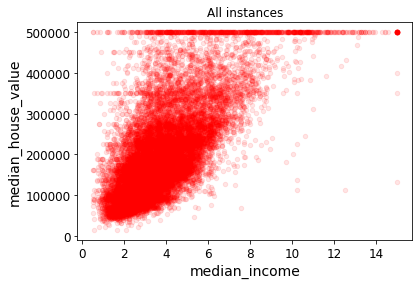

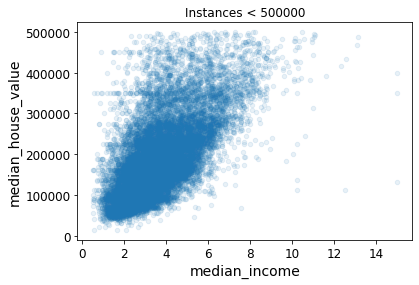

In [45]:
strat_train_set.plot(kind="scatter", x="median_income", y="median_house_value", title="All instances", alpha=0.1, c="red")

strat_train_set_new = strat_train_set[strat_train_set["median_house_value"]<500000]
strat_test_set_new = strat_test_set[strat_test_set["median_house_value"]<500000]

strat_train_set_new.plot(kind="scatter", x="median_income", y="median_house_value", title="Instances < 500000", alpha=0.1)

<div class="alert alert-block alert-success">

**Solution.** The scatter plot in red shows (as we've seen before) an evident straight line at 500,000; this line doesn't appear in the second scatter plot. 

</div>

<div class="alert alert-block alert-success">

__Question 16.__ Write the code to train and test a linear regression model on $strat\_train\_set\_new$ and $strat\_test\_set\_new$. What can you say about the prediction error, compared with what you obtained before?

</div>

In [46]:
#SOLUTION

X_train_new, y_train_new, X_test_new, y_test_new = create_matrices(strat_train_set_new, strat_test_set_new)
train_test_linear_regressor(X_train_new, y_train_new, X_test_new, y_test_new)

59180.055928342445


<div class="alert alert-block alert-success">

**Solution.** After removing those particular instances, we decidedly reduced the prediction error.

</div>